In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import MobileNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB
from tqdm import tqdm

# Setting

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [7]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [8]:
device = torch.device("cuda:0")

# data

In [9]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [10]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [12]:
num_class = 43

In [13]:
len(train_dataset)

26640

12


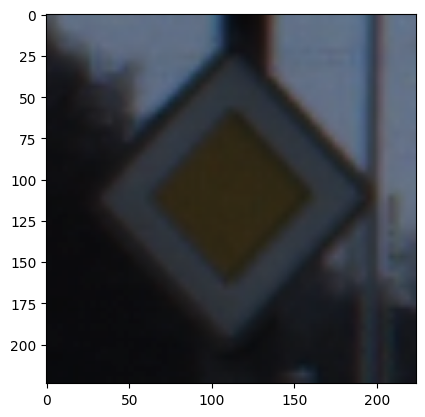

In [14]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [15]:
model = MobileNetV2(output_size=num_class).to(device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MobileNetV2                                                       --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           864
│    │    └─BatchNorm2d: 3-2                                      64
│    │    └─ReLU: 3-3                                             --
│    └─InvertedResidualBlock: 2-2                                 --
│    │    └─LinearBottleneck: 3-4                                 1,984
│    └─InvertedResidualBlock: 2-3                                 --
│    │    └─LinearBottleneck: 3-5                                 5,136
│    └─InvertedResidualBlock: 2-4                                 --
│    │    └─ResBlock: 3-6                                         8,832
│    └─InvertedResidualBlock: 2-5                                 --
│    │    └─LinearB

# training

In [17]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [18]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [19]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [21]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [10:20<00:00,  1.49s/it]


epoch 1 : 0.009293536446281135


100%|██████████| 416/416 [04:08<00:00,  1.68it/s]


epoch 2 : 0.003549688699422404


100%|██████████| 416/416 [01:22<00:00,  5.03it/s]


epoch 3 : 0.001028125847964335


100%|██████████| 416/416 [01:24<00:00,  4.93it/s]


epoch 4 : 0.00045599514194586495


100%|██████████| 416/416 [01:23<00:00,  5.00it/s]


epoch 5 : 0.0002677814914328827


100%|██████████| 416/416 [01:20<00:00,  5.19it/s]


epoch 6 : 0.00020794699702264552


100%|██████████| 416/416 [01:17<00:00,  5.40it/s]


epoch 7 : 0.00013888486124904794


100%|██████████| 416/416 [01:15<00:00,  5.48it/s]


epoch 8 : 0.00010773196980004777


100%|██████████| 416/416 [01:15<00:00,  5.48it/s]


epoch 9 : 0.00010276678932650787


100%|██████████| 416/416 [01:21<00:00,  5.13it/s]

epoch 10 : 0.00010501820525868985


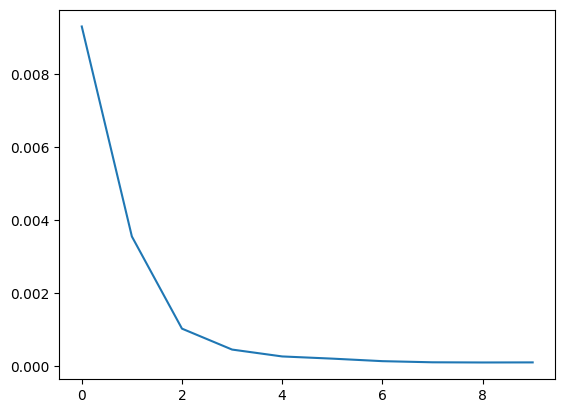

In [22]:
plt.plot(training_loss)

# inference

In [23]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [24]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [25]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [26]:
evaluator = ClassificationEvaluator(num_class, device)

In [27]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [02:26<00:00,  1.35it/s]

0.944972288202692


In [28]:
print(confusion_matrix)

[[ 56   1   0 ...   0   0   0]
 [  0 709   4 ...   0   0   0]
 [  0   7 729 ...   0   0   0]
 ...
 [  0   0   0 ...  58   0   0]
 [  0   0   0 ...   0  50   3]
 [  0   7   0 ...   0   8  55]]


In [29]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.9333333333333333
1         : 0.9847222222222223
2         : 0.972
3         : 0.98
4         : 0.9636363636363636
5         : 0.9809523809523809
6         : 0.8866666666666667
7         : 0.9844444444444445
8         : 0.9488888888888889
9         : 0.99375
10        : 0.9939393939393939
11        : 0.9785714285714285
12        : 0.9492753623188406
13        : 0.9944444444444445
14        : 0.9962962962962963
15        : 0.9952380952380953
16        : 0.9466666666666667
17        : 0.9305555555555556
18        : 0.9358974358974359
19        : 0.7
20        : 0.8888888888888888
21        : 0.6333333333333333
22        : 0.75
23        : 0.9933333333333333
24        : 0.9222222222222223
25        : 0.9479166666666666
26        : 0.9388888888888889
27        : 0.8
28        : 0.98
29        : 0.9444444444444444
30        : 0.92
31        : 0.9481481481481482
32        : 0.8166666666666667
33        : 0.819047619047619
34        : 0.9916666666666667
35        : 0.948717948717

In [30]:
per_class_acc.mean()

0.8918614355535489

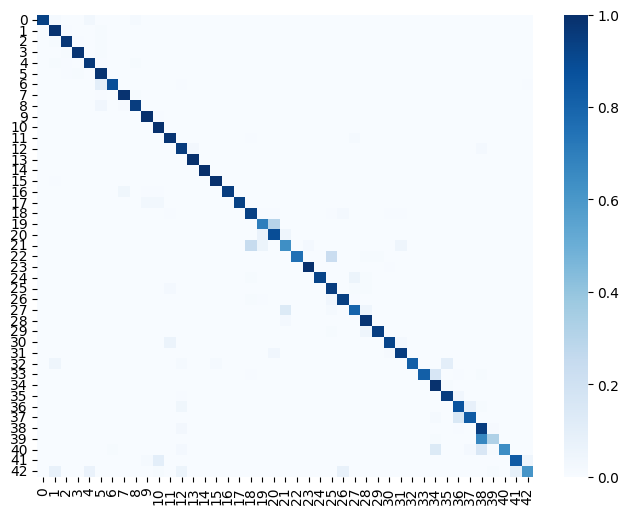

In [31]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [32]:
model_path = artifact_path / 'mobilenetV2.pth'

In [33]:
torch.save(model.state_dict(), model_path)

In [35]:
get_file_size(model_path)

'8.95MB'

In [36]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>